<a href="https://colab.research.google.com/github/mohamedelziat50/Fruit-Recognition-MIU/blob/main/Fruit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Processing project for fruit recognition using the Fruits-360 dataset.

### Import The Necessary Libraries

In [1]:
import kagglehub
import os, sys
import random
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.stats import circmean
from google.colab.patches import cv2_imshow

### Import The [Fruits-360 Dataset](https://www.kaggle.com/datasets/moltean/fruits) From Kaggle

In [2]:
# Load the dataset directly from kaggle (gives us the root path)
kaggle_dataset_path = kagglehub.dataset_download("moltean/fruits")

# Get the correct dataset path, by going inside the folders
dataset_path = os.path.join(kaggle_dataset_path, "fruits-360_100x100", "fruits-360")
print(f"Updated dataset path: {dataset_path}")

# Preview the contents of the path to double-check
print("\nFiles in the Dataset directory:", os.listdir(dataset_path))

Using Colab cache for faster access to the 'fruits' dataset.
Updated dataset path: /kaggle/input/fruits/fruits-360_100x100/fruits-360

Files in the Dataset directory: ['LICENSE', 'Training', 'README.md', 'Test']


### Store the Training & Testing paths independently

In [3]:
# Join the correct paths (checkout out the dataset's folder names on kaggle)
training_path = os.path.join(dataset_path, "Training")
testing_path = os.path.join(dataset_path, "Test")

# Display the Paths
print(f"Training Path: {training_path}")
print(f"Testing Path: {testing_path}\n")

# Check if directories exist
print("Training directory exists:", os.path.exists(training_path))
print("Testing directory exists:", os.path.exists(testing_path))

Training Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Testing Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test

Training directory exists: True
Testing directory exists: True


### Load the training dataset
#### Create a `Fruit` class that will store the fruit's image & label (Training Data)

In [4]:
class Fruit:
  # Constructor With a 2 properties: image & label
  def __init__(self, image, label):
      self.image = image
      self.label = label

  # Getter for image
  @property
  def image(self):
      return self._image

  # Setter for image
  @image.setter
  def image(self, image):
      self._image = image

  # Getter for label
  @property
  def label(self):
      return self._label

  # Setter for label
  @label.setter
  def label(self, label):
      self._label = label

#### Main function that properly fetches the training data & returns a fruits list

In [5]:
def get_categories(fruit_categories, data_path):
    # Store in a list of Fruit Objects that have image & label
    fruits = []

    # Loop over each category
    for category in fruit_categories:
        category_path = os.path.join(data_path, category)

        # Get a list of images in that category
        category_images = os.listdir(category_path)

        # Loop over the images ([:n] here for specific no. of images per category if needed - for quick usage)
        for image in category_images:
            image_path = os.path.join(category_path, image)

            # Read the image using OpenCV & store inside the Fruit class
            fruit = Fruit(cv.imread(image_path), category)
            fruits.append(fruit)

    return sorted(fruits, key=lambda fruit: fruit.label)


#### Get the fruit categories & fruit list objects

In [6]:
# Get a list of all fruit categories (subdirectories) in the training path
fruit_categories = os.listdir(training_path)

# Display how many labels/categories we have
print("Number of Fruit Categories (Labels):", len(fruit_categories), end="\n\n")

# Get a list of all fruits as `Fruit` objects with image & label
fruits = get_categories(fruit_categories, training_path)

# Display how many fruit images we have
print("Number of Fruit Images (Training Data):", len(fruits))

Number of Fruit Categories (Labels): 230

Number of Fruit Images (Training Data): 121111


#### Display a random portion of the fruits using Matplotlib
##### ⚠️ Only converts BGR (OpenCV's default) to RGB when displaying with Matplotlib

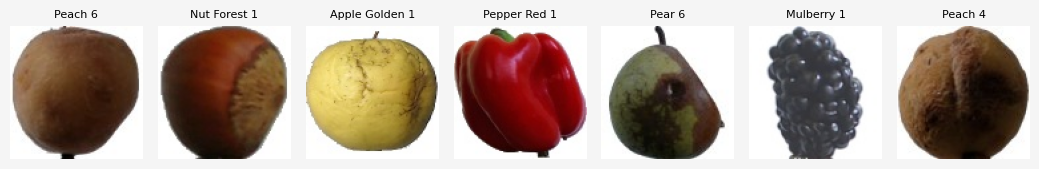

In [7]:
fruits_to_show = random.sample(fruits, 7)
rows, cols = 1, len(fruits_to_show)

plt.figure(figsize=(cols * 1.5, 2), facecolor="whitesmoke")

for index, fruit in enumerate(fruits_to_show):
    # Convert to RGB (Matplotlib) from BGR (OpenCV)
    rgb_image = cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB)

    # Create subplot for this fruit
    plt.subplot(rows, cols, index + 1)  # index +1 because subplot indices start at 1

    # Show image
    plt.imshow(rgb_image)

    # Label on top
    plt.title(fruit.label, fontsize=8)

    # Remove ticks
    plt.axis('off')

plt.tight_layout()
plt.show()

### Image Enhancement & Analysis
#### Preview the Color Histogram (BGR Color Space) for a sample fruit.


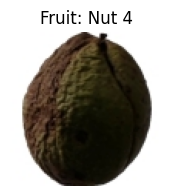

In [8]:
# We want the nuts image for now
fruit = None
for i, the_fruit in enumerate(fruits):
    if the_fruit.label == "Nut 4":
        fruit = fruits[i]
        break

# Convert BGR image to RGB for Matplotlib
rgb_image = cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(2, 2)) # Adjust the figure size (width, height in inches)
plt.imshow(rgb_image)
plt.title(f"Fruit: {fruit.label}")
plt.axis('off') # Hide axes for cleaner image display
plt.show()

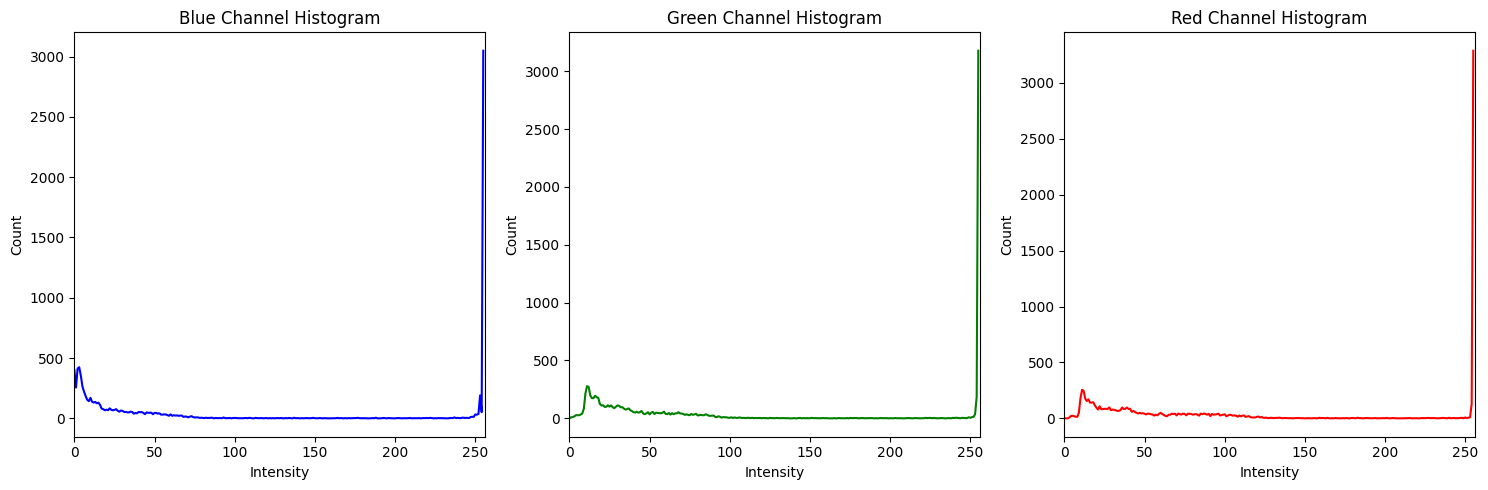

In [9]:
colors = ('b', 'g', 'r')
channel_names = ('Blue', 'Green', 'Red')

# Create figure for subplots
plt.figure(figsize=(15, 5))

# Iterate through channels and plot histograms using subplot indices
for i, (line_color, channel_name) in enumerate(zip(colors, channel_names)):
    plt.subplot(1, 3, i + 1)  # 1 row, 3 columns, current index
    histogram = cv.calcHist([fruit.image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=line_color)
    plt.xlim([0, 256])
    plt.title(channel_name + ' Channel Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Convert BGR To HSV Color Space
##### Hue: Base Color of the pixel (0 to 360 Degrees in theory, but 180 in OpenCV)
##### Saturation: Purity Of the color (lower saturation means it's closer to gray, white, or black. High saturation means it a pure color, 0-100% - 0 to 255)
##### Value: Brightness of the color (Similar to grayscale: Between black & white, which side is it nearer to? 0 = black, 255 = white)

##### Conversion from RGB To HSV is crucial because the white background has near-zero saturation, while the colorful fruits have high saturation, making segmentation straightforward!

###### ⚠️ HSV Is not used to be displayed (will show weird colors). It's only used for processing on the saturation channel

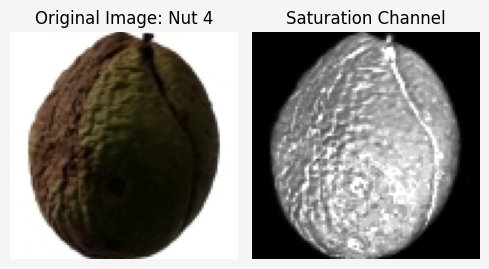


--- Saturation Channel Pixel Analysis ---
Minimum pixel value: 0
Maximum pixel value: 255

Sample saturation values:
  Pixel (60, 78): 225
  Pixel (58, 42): 207
  Pixel (95, 41): 187
  Pixel (54, 96): 0
  Pixel (51, 79): 191

White background pixels have low saturation (near 0)
Fruit region pixels have high saturation (near 255)
--- End Saturation Analysis ---


In [10]:
# Convert the BGR image to HSV
image_hsv = cv.cvtColor(fruit.image, cv.COLOR_BGR2HSV)
hue, saturation, value = cv.split(image_hsv) # Returns numpy arrays

# Display the original image
plt.figure(figsize=(5, 5), facecolor='whitesmoke')

# Original image (convert BGR to RGB for correct colors in matplotlib)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
plt.title(f"Original Image: {fruit.label}")
plt.axis('off')

# Saturation channel
plt.subplot(1, 2, 2)
plt.imshow(saturation, cmap='gray') # Show the colormap/intensities as a grayscale image
plt.title("Saturation Channel")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print information about the saturation channel to showcase its pixel values
print("\n--- Saturation Channel Pixel Analysis ---")
print(f"Minimum pixel value: {np.min(saturation)}")
print(f"Maximum pixel value: {np.max(saturation)}")

# Print sample pixel values from saturation channel
print("\nSample saturation values:")
for i in range(5):
    row, col = random.randint(0, 99), random.randint(0, 99)
    print(f"  Pixel ({row}, {col}): {saturation[row, col]}")

print("\nWhite background pixels have low saturation (near 0)")
print("Fruit region pixels have high saturation (near 255)")
print("--- End Saturation Analysis ---")

#### Display the HSV Histogram

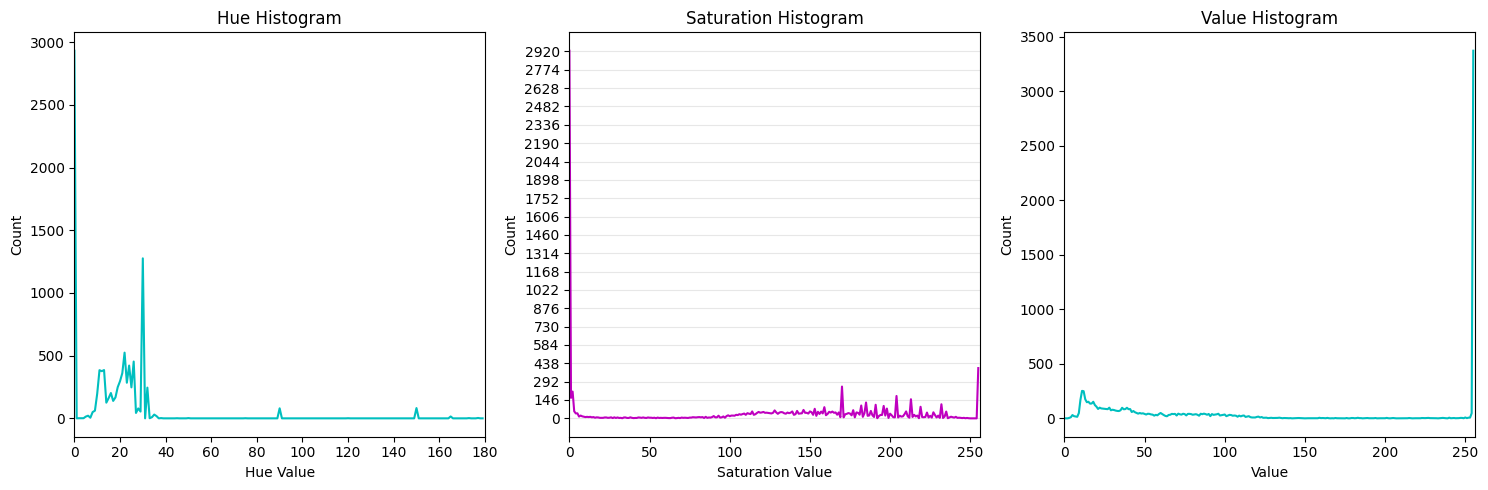


Notice (Saturation Histogram): Almost all intensities revolve around both ends (0 & 255), the others intensities have almost 0 count 


In [11]:
# Declare the histograms individually for a better view
hue_hist = cv.calcHist([hue], [0], None, [180], [0, 180]) # ([numpyarray], [channels(the index is 0 because we have one numpyarray)], [mask], [histogram_size], [range])
saturation_hist = cv.calcHist([saturation], [0], None, [256], [0, 256])
value_hist = cv.calcHist([value], [0], None, [256], [0, 256])

# Plot the histograms
plt.figure(figsize=(15, 5))

# Hue histogram
plt.subplot(1, 3, 1)  # 1 Row, 3 Columns, 1st Histogram
plt.title("Hue Histogram")
plt.plot(hue_hist, color='c')
plt.xlabel("Hue Value")
plt.ylabel("Count")
plt.xlim([0, 180])

# Saturation histogram
plt.subplot(1, 3, 2) # 1 Row, 3 Columns, 2nd Histogram
plt.title("Saturation Histogram")
plt.plot(saturation_hist, color='m')
plt.xlabel("Saturation Value")
plt.ylabel("Count")
plt.xlim([0, 256])

# Add detailed Y-axis ticks For Saturation Histogram
max_count = np.max(saturation_hist)
plt.yticks(np.arange(0, max_count + 1, max_count // 20))
plt.grid(axis='y', alpha=0.3)  # Add horizontal grid lines for better readability

# Value histogram
plt.subplot(1, 3, 3) # 1 Row, 3 Columns, 3rd Histogram
plt.title("Value Histogram")
plt.plot(value_hist, color='c')
plt.xlabel("Value")
plt.ylabel("Count")
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

print("\nNotice (Saturation Histogram): Almost all intensities revolve around both ends (0 & 255), the others intensities have almost 0 count ")

### Image Segmentation
#### Apply a simple binary threshold to the saturation channel. Pixels with an intensity over 15 (Threshold) are set to 255 (white), while those 15 or below become 0 (black, the default value in 8-bit grayscale images).
#### To be safe and not get unintended pixels, we didn't use a lower threshold! Though, sometimes in very dark or very white fruits a very slight 'Under Segmentation' may happen and on a small amount of pixels.

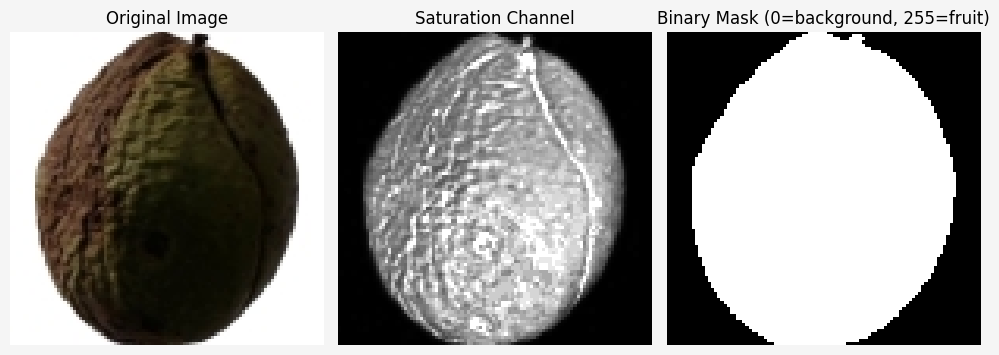


Sample binary mask values (0=background, 255=fruit):
  Pixel (49, 57): 255
  Pixel (96, 50): 255
  Pixel (79, 98): 0
  Pixel (76, 18): 255
  Pixel (7, 97): 0


In [12]:
_, fruit_segmented_mask = cv.threshold(saturation, 15, 255, cv.THRESH_BINARY)

# Display the binary mask (result of thresholding)
plt.figure(figsize=(10, 5), facecolor='whitesmoke')

# Show the original image
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Show the Saturation channel
plt.subplot(1, 3, 2)
plt.imshow(saturation, cmap='gray') # Show the colormap/intensities as a grayscale image
plt.title("Saturation Channel")
plt.axis('off')

# Show the binary mask
plt.subplot(1, 3, 3)
plt.imshow(fruit_segmented_mask, cmap='gray') # Show the colormap/intensities as a grayscale image
plt.title("Binary Mask (0=background, 255=fruit)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Also print some sample pixel values from the binary mask
print("\nSample binary mask values (0=background, 255=fruit):")
for i in range(5):
    row, col = random.randint(0, 99), random.randint(0, 99)
    print(f"  Pixel ({row}, {col}): {fruit_segmented_mask[row, col]}")

#### Now let's visualize the segmented image with it's color
##### Step-by-step logic:
1. Take pixel from first image (fruit.image)

2. Take same pixel from second image (also fruit.image - same image!)

3. Check the mask value at that position (Based on the OpenCV function):
    - Apply mask to control which pixels survive the AND operation

    - If mask = 255 (white, e.g anything non-zero): KEEP the pixel value from the image

    - If mask = 0 (black): SET the pixel to 0 (black)

##### OpenCV Design Note:
The bitwise_and() function requires TWO images even when you only want to apply a mask to ONE image. Using the same image twice is just a workaround because OpenCV doesn't have a simpler apply_mask() function.

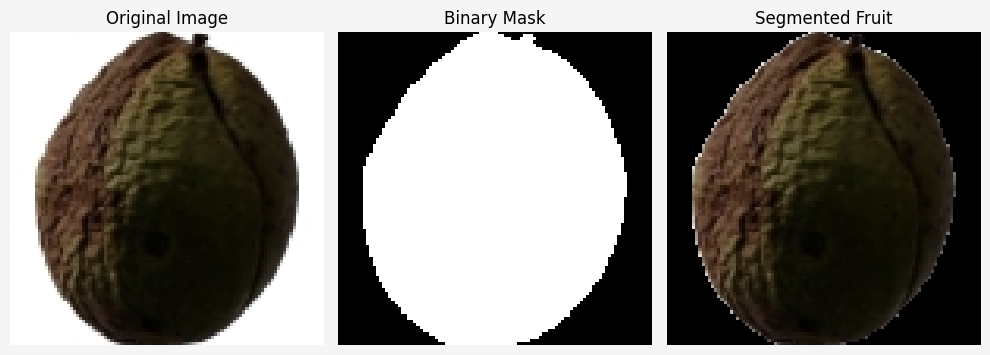

In [13]:
# Create a figure with 3 subplots
plt.figure(figsize=(10, 5), facecolor='whitesmoke')

# 1. Original image
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# 2. Binary mask
plt.subplot(1, 3, 2)
plt.imshow(fruit_segmented_mask, cmap='gray')
plt.title("Binary Mask")
plt.axis('off')

# 3. Showcase the segmented fruit (with it's colors) through the mask
# Create black image (all zeros)
fruit_black = cv.bitwise_and(fruit.image, fruit.image, mask=fruit_segmented_mask)
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(fruit_black, cv.COLOR_BGR2RGB))
plt.title("Segmented Fruit")
plt.axis('off')

plt.tight_layout()
plt.show()

#### Generalized the process of segmentation (all details needed have been explained on the sample fruit above!)
##### Now the generic functions allows us to:
- Test segmentation on any fruit

- Visualize any segmentation

- Use the channels for feature extraction


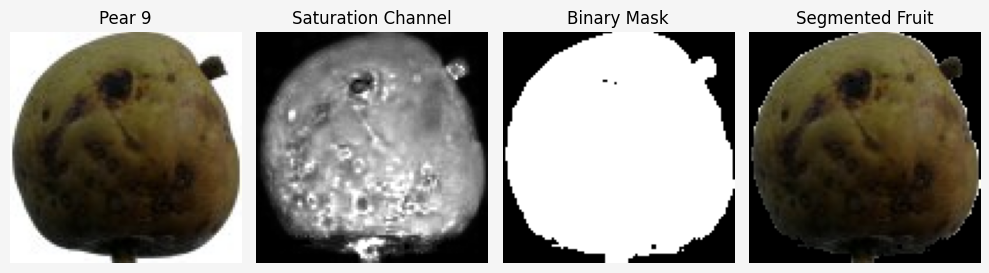

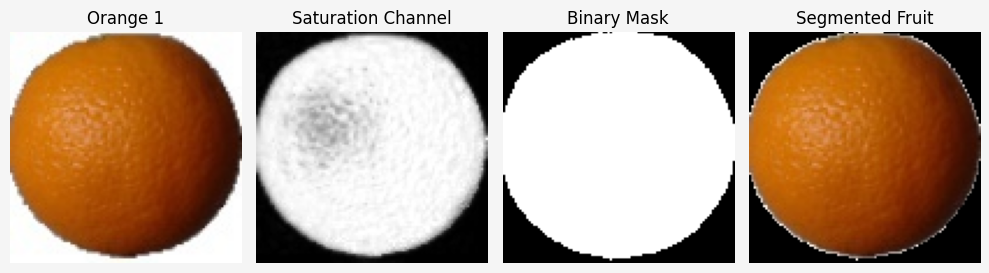

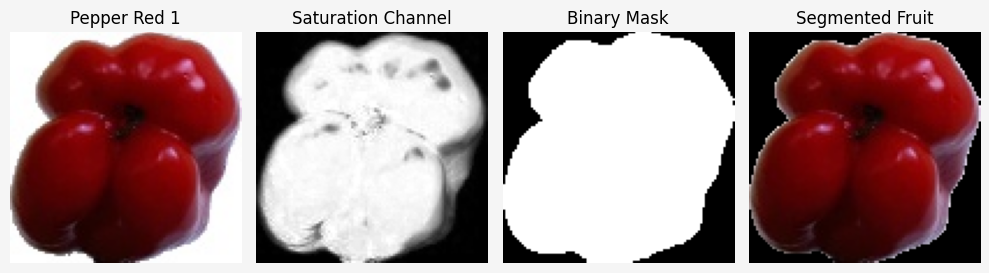

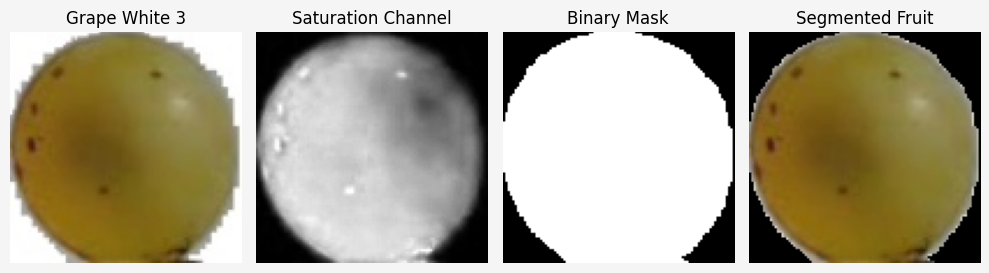

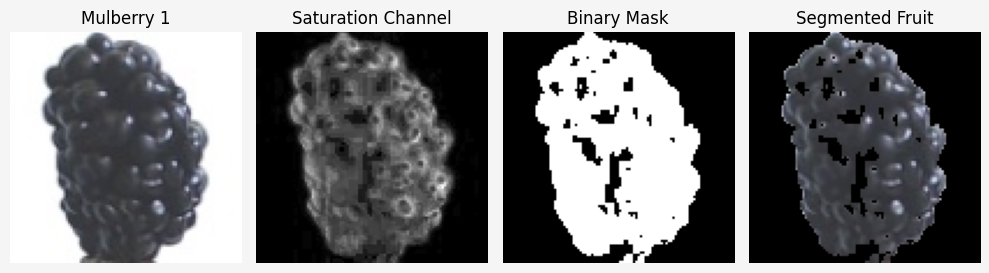

In [14]:
def segment_fruit(fruit):
    # Convert the BGR image to HSV
    image_hsv = cv.cvtColor(fruit.image, cv.COLOR_BGR2HSV)
    hue, saturation, value = cv.split(image_hsv) # Returns numpy arrays

    # Segment the image through simple global thresholding
    _, segmented_mask = cv.threshold(saturation, 15, 255, cv.THRESH_BINARY)

    return [hue, saturation, value, segmented_mask]

def visualize_segmentation(fruit, saturation, segmented_mask):
    # Create a figure with all results for that fruit
    plt.figure(figsize=(10, 3), facecolor="whitesmoke")

    # Show the original image
    plt.subplot(1, 4, 1) # rows, columns, position in the subplot starting from index 1
    plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
    plt.title(f"{fruit.label}")
    plt.axis('off')

    # Show the Saturation channel
    plt.subplot(1, 4, 2)
    plt.imshow(saturation, cmap='gray') # Show the colormap/intensities as a grayscale image
    plt.title("Saturation Channel")
    plt.axis('off')

    # Show the binary mask
    plt.subplot(1, 4, 3)
    plt.imshow(segmented_mask, cmap='gray') # Show the colormap/intensities as a grayscale image
    plt.title("Binary Mask")
    plt.axis('off')

    # Showcase the segmented fruit (with it's colors) through the mask
    # Create black image (all zeros)
    fruit_black = cv.bitwise_and(fruit.image, fruit.image, mask=segmented_mask)
    plt.subplot(1, 4, 4)
    plt.imshow(cv.cvtColor(fruit_black, cv.COLOR_BGR2RGB))
    plt.title("Segmented Fruit")
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Loop over a sample of fruits & showcase the generic functions!
for the_fruit in random.sample(fruits, 5):
    # Segement the fruit & get it's channels if needed aswell
    hue, saturation, value, segmented_mask = segment_fruit(the_fruit)

    # Then visualize the segmentation through matplotlib
    visualize_segmentation(the_fruit, saturation, segmented_mask)


### Image Description & Feature Extraction

#### 4 Features & Descriptors:
- Area (Total no. of white pixels in the segmented mask/fruit)
    - Region-based descriptor because we used a region-based segmentation method (threshold)
    - Completly valid to use since our dataset doesn't face a "scale problem" (unequal capturing distances)
- Average Hue (What is the dominant color?)
- Average Saturation (Is the average saturation a pure color?)
- Average Value (Is the average value, bright or dark?)

#### We'll continue working on the 'sample' fruit that we explained on:
- fruit -> sample fruit object

#### 1. Area

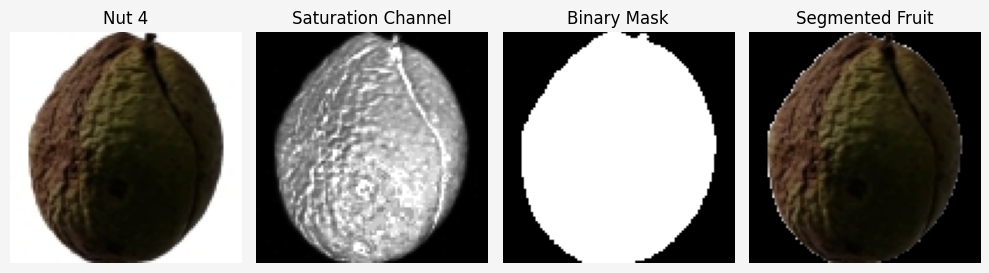


--- Mask Analysis ---
Sample Row: (0=background, 255=fruit)
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Mask datatype: <class 'numpy.ndarray'>
Mask shape (rows, columns): (100, 100)
Mask size (total pixels): 10000
Area = 6436
--- End Mask Analysis ---


In [15]:
# Segement the fruit & get it's channels if needed aswell (using the generic functions!)
hue, saturation, value, segmented_mask = segment_fruit(fruit)

# Then visualize the segmentation through matplotlib
visualize_segmentation(fruit, saturation, segmented_mask)

# Analyze the mask & adjust!
print("\n--- Mask Analysis ---")

# Display a sample row (1st row)
print("Sample Row: (0=background, 255=fruit)\n", segmented_mask[0])

print("\nMask datatype:", type(segmented_mask)) # Numpy Array
print("Mask shape (rows, columns):", segmented_mask.shape) # It's a 2D Array
print("Mask size (total pixels):", segmented_mask.size)

# Count the total no. of segmented pixels only (255)
area = np.count_nonzero(segmented_mask) # Counts True values
print("Area =", area)
print("--- End Mask Analysis ---")


#### 2. Average Hue (What is the dominant color?)
- OpenCV stores hue as 0-179 (to fit in 8-bit: 0-255)

- Real hue range is 0-360 degrees

- Conversion:

    1. fruit_hue * 2 - Convert OpenCV's 0-179 to standard 0-360 range

    2. circmean(..., high=360, low=0) - Compute circular mean in 0-360 space

    3. / 2 - Convert back to OpenCV's 0-179 range

#### 3. Average Saturation (Is the average saturation a pure color?)

#### 4. Average Value (Is the average value, bright or dark?)

##### Apply the average on: Original Image filtered with segmented mask, why? because we only want the fruit pixels (not alongside background - original image) with it's colors (not black/white - mask)

In [16]:
# Analyze the process
print("\n--- Average HSV Channels Analysis ---")

# Preview pre-mask values
print(f"Hue Channel Size & Shape (Pre-mask): {hue.size} & {hue.shape}")
print(f"Saturation Channel Size & Shape (Pre-mask): {saturation.size} & {saturation.shape}")
print(f"Value Channel Size & Shape (Pre-mask): {value.size} & {value.shape}")

# Display a sample row (1st row)
print("\nSample Row: (Hue)\n", hue[0])
print("Sample Row: (Saturation)\n", saturation[0])
print("Sample Row: (Value)\n", value[0])

# Utilize numpy's feature of masking into the arrays immediatly! (Filters True, & removes False values based on the mask!)
fruit_hue = hue[segmented_mask == 255]
fruit_saturation = saturation[segmented_mask == 255]
fruit_value = value[segmented_mask == 255]

print(f"\nHue Channel Size & Shape (Post-mask): {fruit_hue.size} & {fruit_hue.shape}")
print(f"Saturation Channel Size & Shape (Post-mask): {fruit_saturation.size} & {fruit_saturation.shape}")
print(f"Value Channel Size & Shape (Post-mask): {fruit_value.size} & {fruit_value.shape}")

print("\n- They all have the same mask applied, thus same no. of pixels! ")
print("- The mask filtering returns a 1D Array (Shape Changed)")

# Average ONLY the fruit pixels
avg_hue = circmean(fruit_hue * 2, high=360, low=0) / 2 # Use scipy's circular mean (assumes 0-360 range)
avg_saturation = np.mean(fruit_saturation)
avg_value = np.mean(fruit_value)

print("\nAverage Hue =", avg_hue)
print("Average Saturation =", avg_saturation)
print("Average Value =", avg_value)
print("--- End Average HSV Channels Analysis ---")



--- Average HSV Channels Analysis ---
Hue Channel Size & Shape (Pre-mask): 10000 & (100, 100)
Saturation Channel Size & Shape (Pre-mask): 10000 & (100, 100)
Value Channel Size & Shape (Pre-mask): 10000 & (100, 100)

Sample Row: (Hue)
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 150 150   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  20  30  20  16   8  10  10  14   8   8  18  20
   0   0   0 150   6   0   6  20 165   0   0   0   0   0 150 150   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Sample Row: (Saturation)
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   3   4   6  17  38  77 104  78  28  12   5   3
   0   0   0   1   5   7   6   3   2   0   0   0   0   0   1   1   0   0
   0   0   0   0   0   0   0   0   0   

#### Feature Vector - to be used in the Object Recognition part! (Machine Learning)

In [17]:
# Create feature vector (convert numpy types to regular Python types)
fruit_feature_vector = [
    int(area),  # Convert to int
    float(avg_hue),  # Convert numpy float to Python float
    float(avg_saturation),
    float(avg_value)
]
print(f"{fruit.label} Feature Vector: {fruit_feature_vector}")

Nut 4 Feature Vector: [6436, 21.21373237895157, 163.82893101305157, 46.338875077688]


#### Generalized the process of feature extractions (all details needed have been explained on the sample fruit above!)
##### This generic function performs the complete feature extraction process:
- Extracts four key features: area, average hue, average saturation, and average value
- Returns a feature vector that serves as a numerical fingerprint for the fruit


In [18]:
# This function assumes an already segmented fruit & it's associated channels of HSV
def extract_features(hue, saturation, value, segmented_mask):
    # 1. Area
    area = np.count_nonzero(segmented_mask)

    # Utilize numpy's feature of masking into the arrays immediatly! (Filters True, & removes False values based on the mask!)
    fruit_hue = hue[segmented_mask == 255]
    fruit_saturation = saturation[segmented_mask == 255]
    fruit_value = value[segmented_mask == 255]

    # Average ONLY the fruit pixels
    avg_hue = circmean(fruit_hue * 2, high=360, low=0) / 2 # 2. Average Hue
    avg_saturation = np.mean(fruit_saturation) # 3. Average Saturation
    avg_value = np.mean(fruit_value) # 4. Average Value

    # Return feature vector of that fruit
    return [int(area), float(avg_hue), float(avg_saturation), float(avg_value)]

# The sample fruit we're using
print(f"{fruit.label} feature vector: {extract_features(hue, saturation, value, segmented_mask)}")


Nut 4 feature vector: [6436, 21.21373237895157, 163.82893101305157, 46.338875077688]


### Process ALL Fruits & Extract Features
To collect data of all fruits into a dataframe for further processing & operations! (As Training Data)

In [19]:
def process_all_fruits(fruits):
    # Define a list for all features & another for all labels (both correspond in index)
    all_features = []
    all_labels = []

    for fruit in fruits:
        # Segment the fruit
        hue, saturation, value, mask = segment_fruit(fruit)

        # Extract features from the segmented fruit
        feature_vector = extract_features(hue, saturation, value, mask)

        # Store the features & labels in their respective lists
        all_features.append(feature_vector)
        all_labels.append(fruit.label)

    # Create DataFrame with proper column names
    df = pd.DataFrame(
        data=all_features,
        columns=['Area', 'Average Hue', 'Average Saturation', 'Average Value']
    )

    # Add label/class column - associated with a label because it's training data
    df['Label'] = all_labels

    # Return the training data!
    return df

# Process entire dataset
fruit_df = process_all_fruits(fruits)

# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

# Print the pandas fruit feature dataframe with no limit!
fruit_df

,Area,Average Hue,Average Saturation,Average Value,Label
0,6834,12.793744,144.172081,141.785777,Apple 10
1,6524,7.317757,179.534795,123.980687,Apple 10
2,6496,7.376361,176.911792,125.764624,Apple 10
3,7977,12.326224,136.595462,140.741758,Apple 10
4,6435,7.636385,176.527584,126.196426,Apple 10
...,...,...,...,...,...
121106,1733,55.033976,50.454126,52.240623,Zucchini dark 1
121107,1996,58.476406,42.183868,53.874248,Zucchini dark 1
121108,1869,57.797903,42.788122,50.217228,Zucchini dark 1
121109,1648,54.659064,46.624393,46.340413,Zucchini dark 1


#### Feature Analysis & Selection

In [20]:
# Feature statistics
print("FEATURE STATISTICS (All Fruits)")
print("-"*32)
fruit_df.describe()

FEATURE STATISTICS (All Fruits)
--------------------------------


,Area,Average Hue,Average Saturation,Average Value
count,121111.000000,121111.000000,121111.000000,121111.000000
mean,6176.334495,26.664136,139.311603,116.634745
std,1526.583199,24.097408,47.138017,47.428871
min,575.000000,0.001861,22.212000,20.366290
25%,5282.000000,12.643963,106.087094,82.724861
50%,6661.000000,20.521022,142.437500,114.156159
75%,7358.000000,31.194051,176.111031,148.008620
max,8547.000000,179.949193,231.986551,241.379670


### Object Recognition & Classification Phase (Machine Learning)

#### Import the neccesary ML Libraries

In [21]:
# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Models (Algorithms)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Metrics to measure performance
from sklearn.metrics import accuracy_score, confusion_matrix

# For Visualization
import seaborn as sns

#### Training Phase

##### Data Preprocessing: Normalize Features & Convert string to numerical features
##### Note: Most sklearn models expect a NumPy Array, so we don't convert them to a dataframe after normalization & encoding string labels

In [22]:
# Separate features and labels (because only the labels are the string one)
X_train = fruit_df[['Area', 'Average Hue', 'Average Saturation', 'Average Value']]
y_train = fruit_df['Label']

# Normalize features from 0 to 1 (better for the algorithms)
minmax_scaler = MinMaxScaler()
X_train_normalized = minmax_scaler.fit_transform(X_train)  # numpy array

# Encode string labels to numerical (required for the algorithms to work)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # numpy array

# Before Normalization
print("Before Normalization (0 to 1 range)")
print("-"*60)
print(X_train.head())

# After Normalization
print("\nAfter Normalization (0 to 1 range)")
print("-"*60)
print(X_train_normalized[:5])

# Before Encoding String Labels To Numerical
print("\nBefore Encoding String Labels To Numerical")
print("-"*60)
print(np.unique(y_train)[:20])

# After Encoding String Labels To Numerical
print("\nAfter Encoding String Labels To Numerical")
print("-"*60)
print(np.unique(y_train_encoded)[:20])

Before Normalization (0 to 1 range)
------------------------------------------------------------
   Area  Average Hue  Average Saturation  Average Value
0  6834    12.793744          144.172081     141.785777
1  6524     7.317757          179.534795     123.980687
2  6496     7.376361          176.911792     125.764624
3  7977    12.326224          136.595462     140.741758
4  6435     7.636385          176.527584     126.196426

After Normalization (0 to 1 range)
------------------------------------------------------------
[[0.78512293 0.07108682 0.58138645 0.54937618]
 [0.74623683 0.04065576 0.7499613  0.46881504]
 [0.74272454 0.04098143 0.73745739 0.47688667]
 [0.92849975 0.06848872 0.54526853 0.5446524 ]
 [0.73507275 0.04242644 0.73562586 0.4788404 ]]

Before Encoding String Labels To Numerical
------------------------------------------------------------
['Apple 10' 'Apple 11' 'Apple 12' 'Apple 13' 'Apple 14' 'Apple 17'
 'Apple 18' 'Apple 19' 'Apple 5' 'Apple 6' 'Apple 7' 'Apple 8'

##### Model Training & Evaluation
We'll use a simple KNN Model with Euclidean Distance!

Note: When training data for each label was only a single image per label, the accuracy was disastrous!

In [23]:
# Create KNN model with Euclidean distance
knn_model = KNeighborsClassifier(n_neighbors=3, metric='euclidean')

# Train the model
knn_model.fit(X_train_normalized, y_train_encoded) # Normalized Features, & Encoded (Numerical) Labels
print("Model trained successfully!")

# See how well it learned the training data
train_predictions = knn_model.predict(X_train_normalized) # Returns the predicted labels!
train_accuracy = accuracy_score(y_train_encoded, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2%}")

Model trained successfully!
Training Accuracy: 99.38%


Showcase classification accuracy using confusion matrix

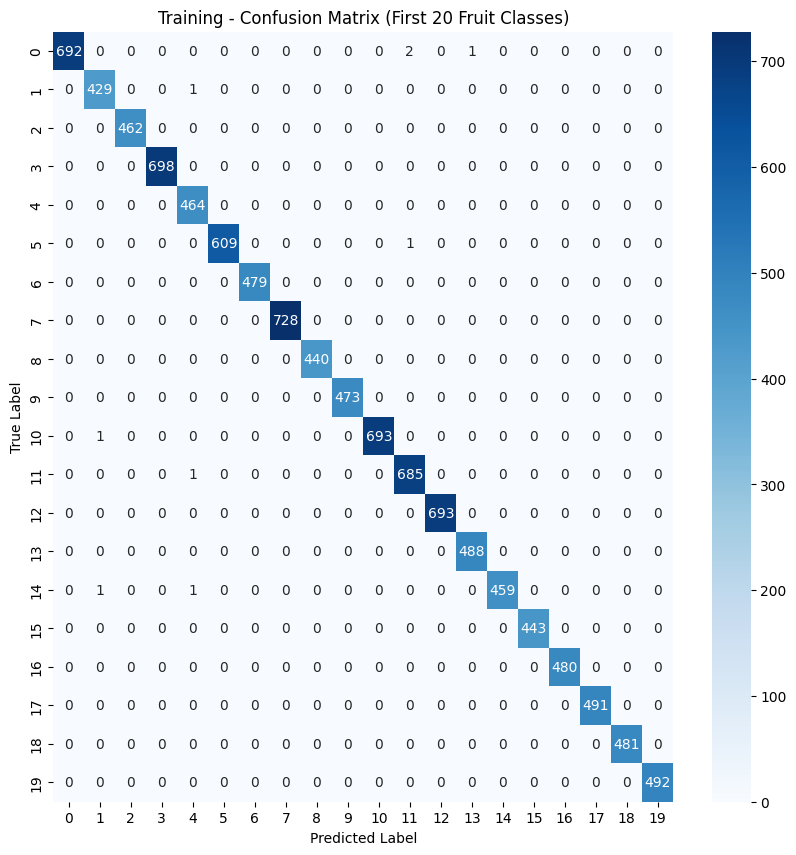

In [24]:
def visualize_confusion_matrix(labels, predicted_labels):
    # Create confusion matrix
    cm = confusion_matrix(labels, predicted_labels)

    # Show a smaller version (first 20 classes) so it's readable
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues') # annot: shows numbers in heatmap, fmt: decimal
    plt.title('Training - Confusion Matrix (First 20 Fruit Classes)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

visualize_confusion_matrix(y_train_encoded, train_predictions)

#### Testing Phase

##### Load Testing Data into dataframe

In [25]:
# Get a list of all fruit categories (subdirectories) in the testing path
fruit_test_categories = os.listdir(testing_path)

# Display how many labels/categories we have
print("Number of Fruit (Testing) Categories (Labels):", len(fruit_test_categories), end="\n\n")

# Get a list of all fruits as `Fruit` objects with image & label
fruits_testing = get_categories(fruit_test_categories, testing_path)

# Display how many fruit images we have
print("Number of Fruit Images (Testing Data):", len(fruits_testing))

# Process entire dataset
fruit_testing_df = process_all_fruits(fruits_testing)
fruit_testing_df

Number of Fruit (Testing) Categories (Labels): 230

Number of Fruit Images (Testing Data): 40383


,Area,Average Hue,Average Saturation,Average Value,Label
0,7562,12.860030,137.519968,137.775060,Apple 10
1,7002,9.076482,153.709940,141.640246,Apple 10
2,7060,10.236329,140.102691,150.647167,Apple 10
3,6783,13.718909,139.150523,141.147427,Apple 10
4,7243,10.598833,134.526025,151.126191,Apple 10
...,...,...,...,...,...
40378,1687,53.623902,47.359218,47.063426,Zucchini dark 1
40379,1717,57.685210,52.263250,54.337798,Zucchini dark 1
40380,1885,58.772094,41.653050,56.000000,Zucchini dark 1
40381,1949,61.883930,43.476142,59.062596,Zucchini dark 1


##### Data Preprocessing: Normalize Features & Convert string to numerical features
Why use the SAME scaler from training?
- Because the model learned from training data scaling. If you scale testing data differently, the model won't understand it!

Why .transform() not .fit_transform()?
- .fit_transform(): Learns NEW scaling rules AND applies them

- .transform(): Applies ALREADY LEARNED rules

In [26]:
# Separate features and labels from TESTING data
X_test = fruit_testing_df[['Area', 'Average Hue', 'Average Saturation', 'Average Value']]
y_test = fruit_testing_df['Label']  # KEEP THE LABELS! (to be used in comparision later)

# Normalize testing features using the SAME scaler from training
X_test_normalized = minmax_scaler.transform(X_test)  # NOT .fit_transform!

# Encode testing labels using the SAME encoder from training
y_test_encoded = label_encoder.transform(y_test)  # NOT .fit_transform!

print("Testing data prepared!")

Testing data prepared!



##### Model Testing & Evaluation
Note: .fit() wasn't used to train the model with the features & labels.
Immediatly predicts on prepared testing (unseen) data!

In [27]:
# Make predictions on TEST data
test_predictions = knn_model.predict(X_test_normalized)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_encoded, test_predictions)
print(f"Training Accuracy (from before): {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print()

# Compare training vs test accuracy
if test_accuracy > train_accuracy:
    print("Wow! Model performs better on test data! (Rare but possible)")
elif abs(test_accuracy - train_accuracy) < 0.05:  # Less than 5% difference
    print("Good! Model generalizes well to new data.")
else:
    print("Warning: Model might be overfitting (memorized training data)")

Training Accuracy (from before): 99.38%
Test Accuracy: 89.67%



Showcase testing classification accuracy using confusion matrix

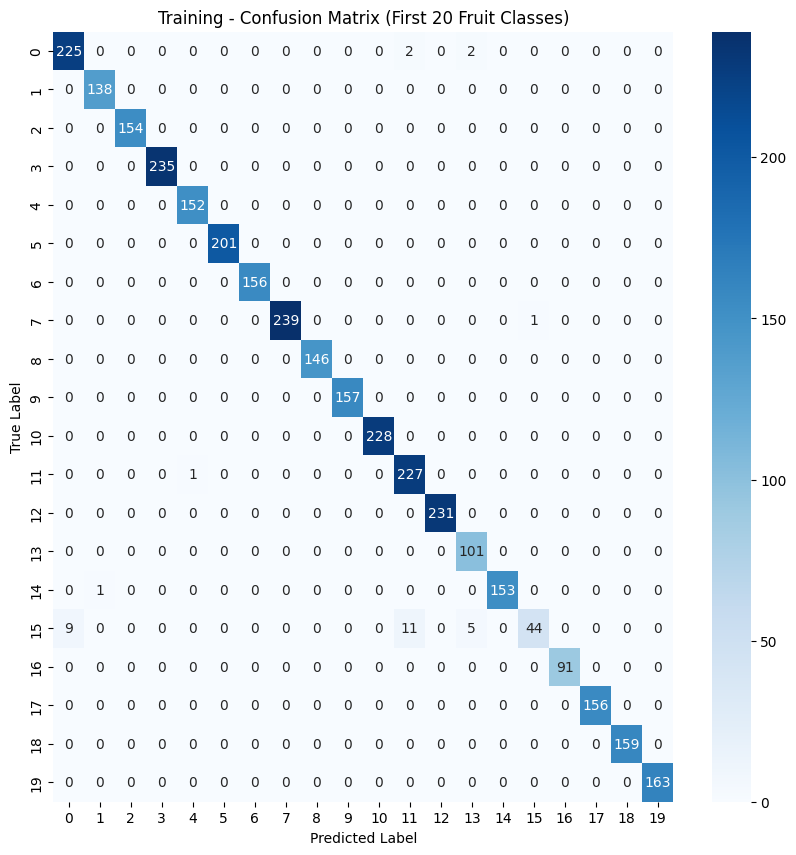

In [28]:
# Create confusion matrix
visualize_confusion_matrix(y_test_encoded, test_predictions)

##### Train & Test other models (skip explaination, same concept)
- Random Forest

In [29]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_normalized, y_train_encoded)

# Predict & Evaluate
rf_train_pred = rf_model.predict(X_train_normalized)
rf_test_pred = rf_model.predict(X_test_normalized)

rf_train_acc = accuracy_score(y_train_encoded, rf_train_pred)
rf_test_acc = accuracy_score(y_test_encoded, rf_test_pred)

print(f"Random Forest - Training Accuracy: {rf_train_acc:.2%}")
print(f"Random Forest - Testing Accuracy:  {rf_test_acc:.2%}")

Random Forest - Training Accuracy: 100.00%
Random Forest - Testing Accuracy:  92.04%


#### Prediction Visualization For Selected Model (Random Forest)
The label_encoder.classes_ is a list of fruit names. The encoded numbers (0, 1, 2, ...) are just indexes into this list.

So y_true[idx] = 3 means "get the 4th fruit name in the list"

Check BOTH data match in index:
Fruits Testing List length: 40383  Type: <class 'list'>
Random Forest Predictions length: (40383,)  Type: <class 'numpy.ndarray'>



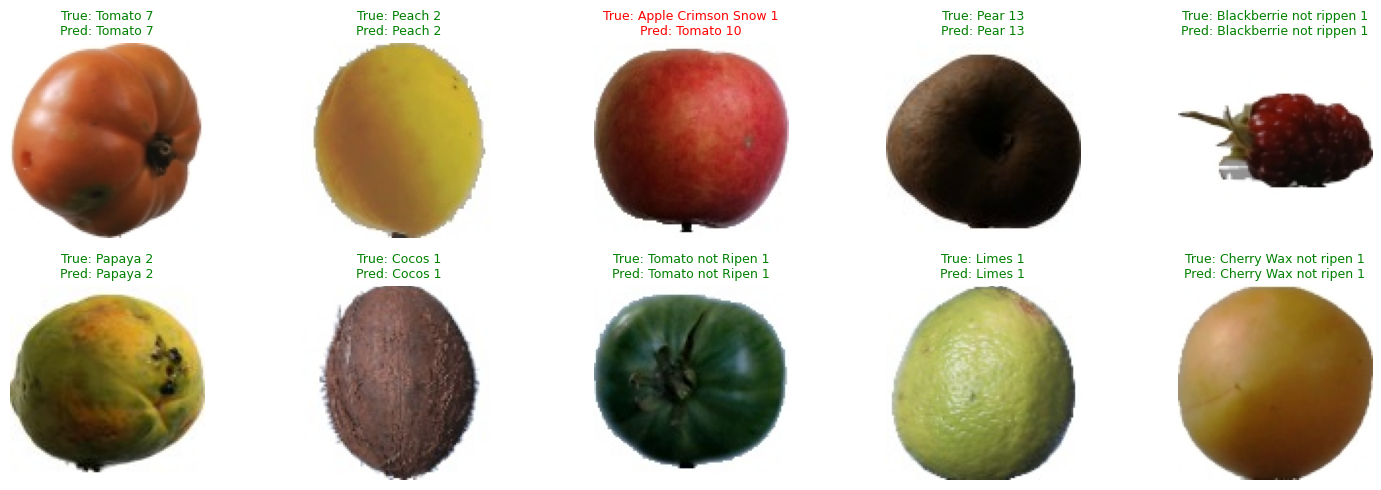

In [88]:
def visualize_predictions(fruits, y_pred, n=10):
    # Plot the figure
    plt.figure(figsize=(15, 5))

    # Pick random fruits through index
    indices = random.sample(range(len(fruits)), n)

    # Loop over the random fruits to display true vs pred.
    for i, idx in enumerate(indices):
        # Acess the fruit through index
        fruit = fruits[idx]

        # Place it in the figure
        plt.subplot(2, n//2, i+1)

        # Show image (convert BGR to RGB)
        img_rgb = cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB)
        plt.imshow(img_rgb)

        # Get true label from Fruit object (Already stored in the Fruit object!)
        true_name = fruit.label

        # Get predicted label from label_encoder (y_pred[idx] is a numeric value, we need the label's name which was before encoding)
        pred_name = label_encoder.classes_[y_pred[idx]]

        # Show results
        color = 'green' if true_name == pred_name else 'red'
        plt.title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Double check both correspond in index (by length)
print("Check BOTH data match in index:")
print("Fruits Testing List length:", len(fruits_testing), " Type:", type(fruits_testing))
print("Random Forest Predictions length:", rf_test_pred.shape, " Type:", type(rf_test_pred))
print()

# Call the visualization
visualize_predictions(fruits_testing, rf_test_pred, n=10)

#### Save the final model for future use (web implementation!)

In [89]:
import joblib

# Package everything
model_bundle = {
    'rf_model': rf_model,
    'scaler': minmax_scaler,
    'encoder': label_encoder
}

joblib.dump(model_bundle, 'fruit_model.joblib')
print("Model saved successfully!")

Model saved successfully!


In [90]:
# Incase needed, save & download to/from drive (Over 1.9 GB)
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save model to Drive
import joblib
joblib.dump({
    'model': rf_model,
    'scaler': minmax_scaler,
    'label_encoder': label_encoder
}, '/content/drive/MyDrive/fruit_model.joblib')

print("Model saved to Google Drive!")

Mounted at /content/drive
Model saved to Google Drive!
